I was working on a model where I knew the value of $Y$ when $X = 0$. This left me in the uncomfortable position of deciding whether to give the intercept a strong prior or simply fix it to a constant value. 
Since I was too lazy to work out the math by hand, I decided to go for a computationally assisted approach to determine whether that choice made sense.

In [1]:
#| code-fold: true
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

## Where it fails

In the past, I've used the `heights` dataset from Karl Pearson and Alice Lee to teach linear regression.
It's a classic dataset where the goal is to predict a daughter's height ($Y$) from her mother's height ($X$).
Let's have a quick look at it.

In [2]:
#| code-fold: true
#| classes: .center-table-40
url_heights = "https://raw.githubusercontent.com/tomicapretto/introduccion_pymc/main/datos/heights.txt"
df_heights = pd.read_table(url_heights, sep=" ")
df_heights

,daughter_height,mother_height
0,52.5,59.5
1,52.5,59.5
2,53.5,59.5
3,53.5,59.5
4,55.5,59.5
...,...,...
5519,71.5,70.5
5520,73.5,63.5
5521,73.5,63.5
5522,73.5,63.5


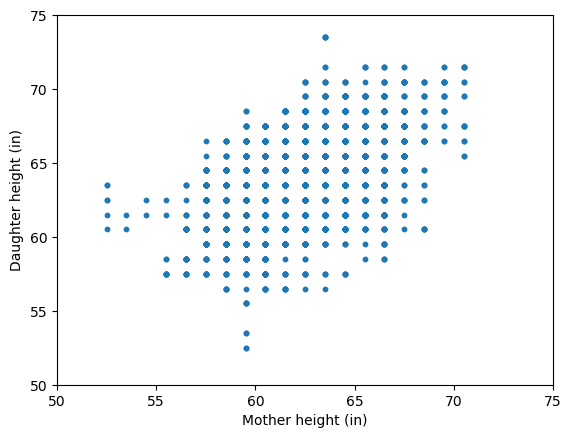

In [3]:
#| echo: false
fig, ax = plt.subplots()
ax.scatter(df_heights["mother_height"], df_heights["daughter_height"], s=10)
ax.set(xlabel="Mother height (in)", ylabel="Daughter height (in)", xlim=(50, 75), ylim=(50, 75));

### Model with intercept

A simple linear regression model with both an intercept and a slope is an obvious choice.

$$
Y_i \mid X_i = x_i \sim \text{Normal}(\alpha + \beta x_i, \sigma^2)
$$

And in Python it just takes us a few lines of code:

In [4]:
y = df_heights["daughter_height"].to_numpy()
X = np.column_stack([np.ones_like(y), df_heights["mother_height"]])
model = sm.OLS(y, X).fit()

The parameter summary is the following:

In [5]:
#| classes: .center-table-60
#| echo: false
model.summary(slim=True).tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,29.7984,0.790,37.703,0.000,28.249,31.348
x1,0.5449,0.013,43.125,0.000,0.520,0.570


If you've ever had to interpret the coefficients of a regression model, you might have said: "The average height of daughters whose mothers are 0 inches tall is 29.8 inches". Of course, it makes no sense.

### Model without intercept

A natural first reaction might be to question whether you need an intercept at all. In that case, you might go ahead and fit the following model without one:

$$
Y_i \mid X_i = x_i \sim \text{Normal}(\beta x_i, \sigma^2)
$$

In [6]:
model_no_intercept = sm.OLS(y, X[:, 1]).fit()

Now, the parameter summary contains a single record for the slope:

In [7]:
#| classes: .center-table-60
#| echo: false
model_no_intercept.summary(slim=True).tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
x1,1.0210,0.001,1871.328,0.000,1.020,1.022


### Comparison

Instead of focusing on the exact values of the estimated slopes, let's look at the fitted regression lines overlaid on the original scatterplot.

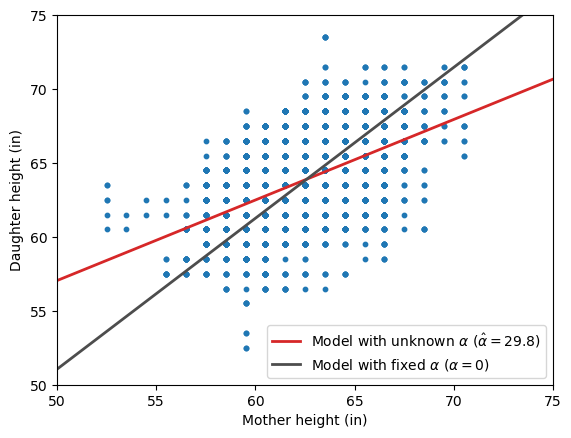

In [8]:
#| code-fold: true
fig, ax = plt.subplots()
ax.scatter(df_heights["mother_height"], df_heights["daughter_height"], s=10)
ax.set(xlabel="Mother height (in)", ylabel="Daughter height (in)", xlim=(50, 75), ylim=(50, 75));

ax.axline((0, model.params[0]), slope=model.params[1], color="C3", lw=2, label="Model with unknown $\\alpha$ ($\\hat{\\alpha}=29.8$)")
ax.axline((0, 0), slope=model_no_intercept.params[0], color="0.3", lw=2, label="Model with fixed $\\alpha$ ($\\alpha=0$)")
ax.legend();

At first glance, the two models produce remarkably different regression lines, but it is not immediately clear which one best describes the association between the heights.
To shed some light on this, let's look at the RMSE for each model:

In [9]:
def compute_rmse(y, y_hat):
    return np.sqrt(np.mean((y - y_hat) ** 2))

rmse_1 = compute_rmse(y, model.predict(X))
rmse_2 = compute_rmse(y, model_no_intercept.predict(X[:, 1]))

print(f"Model with intercept RMSE: {rmse_1:.3f}")
print(f"Model without intercept RMSE: {rmse_2:.3f}")

Model with intercept RMSE: 2.262
Model without intercept RMSE: 2.536


### Conclusion

The model without an intercept, though initially appealing in theory, ultimately produces larger errors. This is something we could have expected: forcing the intercept to a fixed value, especially when $X = 0$ lies outside the range of the observed data, can bias the slope estimate.

As George Box famously remarked, _all models are wrong, but some are useful_.
Usefulness often depends on the range of the explanatory variables, and a model that performs well within a given range may fail to do so outside it.

## Where it works

The previous example made it clear that haphazardly fixing the intercept to a value can have unintended consequences.

However, in the problem that motivated this blog post, I do have a solid basis for fixing the intercept to a specific value.

Let's now run a simulation in which the model we use matches the underlying data generating process and $X=0$ lies within the range of observed data.

This turn, we will simulate data using a linear regression model with $\alpha=2$, $\beta=1$, and $\sigma=2$.

We will run $S=1000$ iterations where we observe $N=50$ data points with $X \in [0, 10]$. In the first scenario, we will estimate both $\alpha$ and $\beta$. In the second, we will fix $\alpha$ to its true value, and only estimate $\beta$. In both cases, we will record the point estimates as well as the 95% confidence interval for the slope as reported by `statsmodels`.

To illustrate, here's what the simulated data will look like in any given iteration:

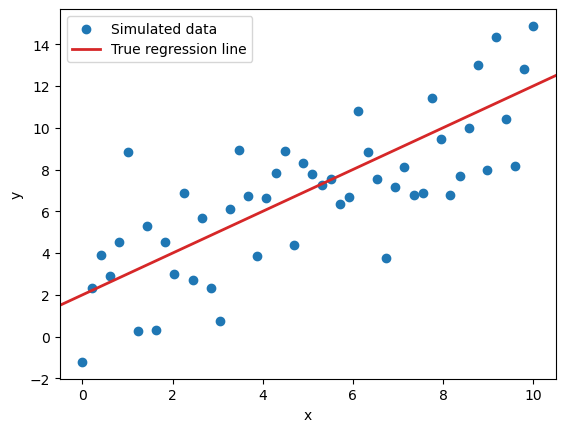

In [10]:
#| code-fold: true
N = 50  # Number of data points
S = 1000 # Number of simulations

a_true = 2.0 # True intercept
b_true = 1.0 # True slope
sigma_true = 2.0 # True residual standard deviation

rng = np.random.default_rng(1234)

x = np.linspace(0, 10, num=N)
y = rng.normal(loc=a_true + b_true * x, scale=sigma_true)

fig, ax = plt.subplots()
ax.scatter(x, y, label="Simulated data")
ax.axline((0, a_true), slope=b_true, color="C3", lw=2, label="True regression line")
ax.set(xlabel="x", ylabel="y")
ax.legend();

### Scenario 1: Unknown intercept

Here we just simulate datasets and estimate $\alpha$ and $\beta$ via classic OLS.

Let's run the simulation and explore the sampling distribution of $\hat{\alpha}$ and $\hat{\beta}$.

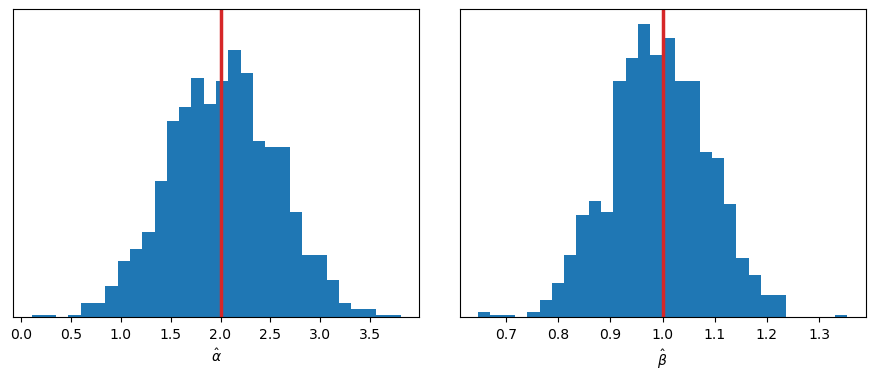

In [11]:
#| code-fold: true
unknown_intercept_output = {
    "intercept": [],
    "slope": [],
    "slope_ci": []
}

X = np.column_stack([np.ones_like(x),x])

for s in range(S):
    y = rng.normal(loc=a_true + b_true * x, scale=sigma_true)
    model = sm.OLS(y, X).fit()
    conf_int = model.conf_int()

    unknown_intercept_output["intercept"].append(model.params[0].item())
    unknown_intercept_output["slope"].append(model.params[1].item())
    unknown_intercept_output["slope_ci"].append(conf_int[1])


fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)

axes[0].hist(unknown_intercept_output["intercept"], bins=30)
axes[1].hist(unknown_intercept_output["slope"], bins=30)

axes[0].set(xlabel="$\\hat{\\alpha}$", yticks=[])
axes[1].set(xlabel="$\\hat{\\beta}$");

axes[0].axvline(a_true, color="C3", lw=2.5);
axes[1].axvline(b_true, color="C3", lw=2.5);

There are no surprises here: both distributions are centered around the true values of $\alpha$ and $\beta$.

### Scenaro 2: Fixed intercept

In this other scenario, we again simulate datasets and estimate parameters via OLS, but this time we fix the value of the intercept to $\alpha=2$.

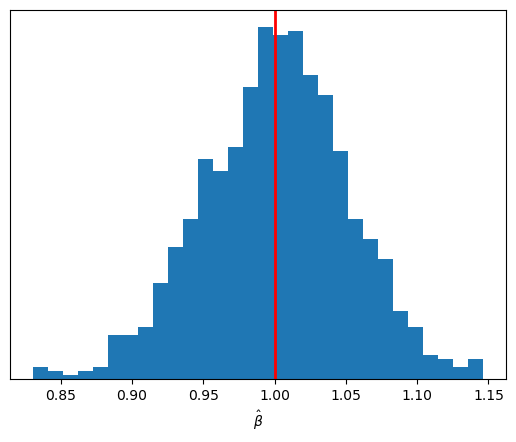

In [12]:
#| code-fold: true
known_intercept_output = {
    "slope": [],
    "slope_ci": []
}

for s in range(S):
    y = rng.normal(loc=a_true + b_true * x, scale=sigma_true)
    model = sm.OLS(y - a_true, x).fit()
    known_intercept_output["slope"].append(model.params[0].item())
    known_intercept_output["slope_ci"].append(model.conf_int()[0])

fig, ax = plt.subplots()
ax.hist(known_intercept_output["slope"], bins=30)
ax.set(xlabel="$\\hat{\\beta}$", yticks=[])
ax.axvline(b_true, color="red", lw=2);

The sampling distribution of $\hat{\beta}$ is again centered on its true value, but it is now more concentrated around that center than before.

To finalize, we can also compare the sampling distribution of the length of the 95% CI for $\hat{\beta}$ between the two scenarios.

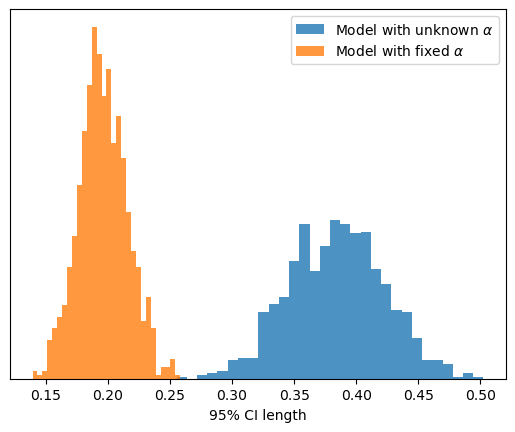

In [13]:
#| code-fold: true
slope_cis_1 = np.vstack(unknown_intercept_output["slope_ci"])
slope_cis_2 = np.vstack(known_intercept_output["slope_ci"])

bins = np.linspace(0.1, 0.6, num=30)

fig, ax = plt.subplots()
ax.hist(
    np.diff(slope_cis_1, axis=-1).flatten(),
    density=True,
    color="C0",
    bins=30,
    alpha=0.8,
    label="Model with unknown $\\alpha$",
)

ax.hist(
    np.diff(slope_cis_2, axis=-1).flatten(),
    density=True,
    color="C1",
    bins=30,
    alpha=0.8,
    label="Model with fixed $\\alpha$",
)

ax.set(xlabel="95% CI length", yticks=[])
ax.legend();

Not only does the sampling distribution of $\hat{\beta}$ have lower uncertainty, but the confidence intervals in each individual iteration are also more concentrated around the estimate.

## Summary

Even if the intercept’s meaning doesn't make sense, leaving it out of a regression model is usually a bad idea.

That said, there are scenarios where fixing the intercept to zero or to another meaningful value can be justified. And in such cases, if we are right, doing so may actually improve the estimation of other unknown parameters.